CS244 Assignment 7 - Group 8
===============

* Kevin Rothi (leader)
* John Lanier
* J.Y. Ku

Github Repository 
https://github.com/JBLanier/cs244fall2017/ 


View this notebook online at: https://github.com/JBLanier/cs244fall2017/blob/master/assignment_7/Group8Assignment7.ipynb

Up until this point, all of our device generated datasets were from J.B. (including the dataset we initially used for this assignment). We were stumped to alleviated huge amounts of noise that occured anytime that motion was introduced. 

However, very recently, we have recorded a dataset from J.Y. for assignment 8, and the noise problems were completely gone. J.B.'s body seems to be the "bug" in our algorithm that we couldn't find until now.

With permission form Takashi, we have used J.Y.'s dataset for this assignment, and we will use it again in assignment 8.

### Code
Our code in this notebook is nearly identical to the code used in assignment 6; we now simply loop over multiple activities instead of a single activity. The board and server ran the same processes as before.


# Activity Classification

Classification on J.Y.'s motion went very well and very poorly depending on the activity. Our SVM was trained on J.B.'s motion. The output from the cell below shows our test results:

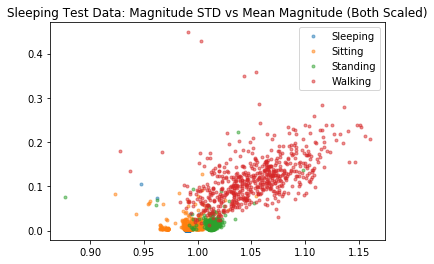

Cross Validation Accuracy: 0.8679166666666667
Test Error Rate on a 2nd 10 minute Sleeping data set: 0.0016666666666667052
Test Error Rate on a 2nd 10 minute Sitting data set: 0.4
Test Error Rate on a 2nd 10 minute Standing data set: 0.0050000000000000044
Test Error Rate on a 2nd 10 minute Walking data set: 0.16333333333333333


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import math
import pandas as pd
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import sklearn
np.random.seed(42)
%matplotlib inline

def getGeneratedFeatureData(raw_data, window_size):
    gen_features = np.full(((len(raw_data)//window_size),3),-1.0)
    for window_num, window_start_index in enumerate(range(0,len(raw_data),window_size)):
        # Check for case in which last window isn't as large as desired window_size
        if (window_start_index + window_size) > len(raw_data):
            #print("Last window at {} was too small, excluding it.".format(window_start_index))
            break
        # Gather magnitudes of data points in window
        window_magnitudes = np.full(window_size,-1.0)
        for window_index, raw_data_index in enumerate(range(window_start_index, window_start_index + window_size)):
            magnitude = np.linalg.norm(raw_data[raw_data_index][-4:-1])
            window_magnitudes[window_index] = magnitude 
            #print("c: {} index: {} W: {} values: {} magnitude: {}".format(raw_data[raw_data_index,-1],raw_data_index,window_num,raw_data[raw_data_index][:-1],magnitude))
       
        #print("Window:\n{}".format(window_magnitudes))
        #print("Mean: {} Std: {}".format(window_magnitudes.mean(),window_magnitudes.std()))
        gen_features[window_num,0] = window_magnitudes.mean()
        gen_features[window_num,1] = window_magnitudes.std()
        gen_features[window_num,2] = raw_data[0,-1]
    return gen_features

# Pull in Raw Training Data
tr_sleeping = np.genfromtxt('sleeping.csv', delimiter=',')[1:]
tr_sitting = np.genfromtxt('sitting.csv', delimiter=',')[1:]
tr_standing = np.genfromtxt('standing.csv', delimiter=',')[1:]
tr_walking = np.genfromtxt('walking.csv', delimiter=',')[1:]

# Add Class Labels
tr_sleeping = np.concatenate((tr_sleeping,np.full((len(tr_sleeping),1),1)),axis=1)
tr_sitting  = np.concatenate((tr_sitting ,np.full((len(tr_sitting) ,1),2)),axis=1)
tr_standing = np.concatenate((tr_standing,np.full((len(tr_standing),1),3)),axis=1)
tr_walking  = np.concatenate((tr_walking ,np.full((len(tr_walking) ,1),4)),axis=1)

# Trim out all but xyz and class data
tr_sleeping = tr_sleeping[:,-4:]
tr_sitting = tr_sitting[:,-4:]
tr_standing = tr_standing[:,-4:]
tr_walking = tr_walking[:,-4:]

# Generate our Final Training Data from windows of raw data (std magnitude and mean magnitude only)
window_size = 50
tr_sleeping = getGeneratedFeatureData(tr_sleeping,window_size)
tr_sitting = getGeneratedFeatureData(tr_sitting,window_size)
tr_standing = getGeneratedFeatureData(tr_standing,window_size)
tr_walking = getGeneratedFeatureData(tr_walking,window_size)

# Put Training data in one np array
train = np.concatenate((tr_sleeping,tr_sitting,tr_standing,tr_walking))

tr_X = train[:,:-1]
tr_Y = train[:,-1]

# Scale the data
scaler = StandardScaler()
scaler.fit(tr_X)
tr_X = scaler.transform(tr_X)

# Plot
df = pd.DataFrame(train)
df.columns = ['Mean', 'STD', 'Class']
groups = df.groupby('Class')
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for group, label in zip(groups,['Sleeping','Sitting','Standing','Walking']):
    group = group[1]
    ax.plot(group.Mean, group.STD, marker='o', alpha = 0.5, linestyle='', ms=3, label=label)
ax.legend()
plt.title("Sleeping Test Data: Magnitude STD vs Mean Magnitude (Both Scaled)")
plt.show()

# Cross Validate on an SVM
clf = svm.SVC()
scores = cross_val_score(clf, tr_X, tr_Y, cv=5)
print('Cross Validation Accuracy: {}'.format(np.mean(scores)))

clf.fit(tr_X,tr_Y)

# Gather test data sets and set class labels
test_sleeping = np.genfromtxt('jy_sleeping.csv', delimiter=',')[1:]
test_sleeping = np.concatenate((test_sleeping,np.full((len(test_sleeping),1),1)),axis=1)

test_sitting = np.genfromtxt('jy_sitting.csv', delimiter=',')[1:]
test_sitting = np.concatenate((test_sitting,np.full((len(test_sitting),1),2)),axis=1)

test_standing = np.genfromtxt('jy_standing.csv', delimiter=',')[1:]
test_standing = np.concatenate((test_standing,np.full((len(test_standing),1),3)),axis=1)

test_walking = np.genfromtxt('jy_walking.csv', delimiter=',')[1:]
test_walking = np.concatenate((test_walking,np.full((len(test_walking),1),4)),axis=1)

test_sets = [test_sleeping,test_sitting,test_standing,test_walking]
test_set_names = ["Sleeping","Sitting","Standing","Walking"]

error_rates = [-1] * len(test_sets)

# Evaluate classifier performance on each test data set
for i in range(0,len(test_sets)):
    test_data = test_sets[i]
    test_data = test_data[:,-4:]
    test_data = getGeneratedFeatureData(test_data,window_size)
    test_X = test_data[:,:-1]
    test_X = scaler.transform(test_X)
    test_Y = test_data[:,-1]
    test_accuracy = sklearn.metrics.accuracy_score(test_Y,clf.predict(test_X))
    test_error_rate = 1.0 - test_accuracy
    error_rates[i] = test_error_rate
    print("Test Error Rate on a 2nd 10 minute {} data set: {}".format(test_set_names[i],test_error_rate))

- For sleeping, since both the training data and J.Y. test data contained essentially no motion, classification was extremely accurate (0.2% error).

- The SVM (trained on J.B.'s movements) had a difficult time (40% error) correctly labeling J.Y.'s sitting activity. (Generally incorrect guesses were labeled as standing)

- The low error rate for standing (.5%) is extremely odd however. Training error is far greater, and a second test set of J.B. standing had around 30% error. J.Y.'s motions are clearly far on the "correct" side of the SVM's boundaries.

- It seems that J.Y.'s sitting and standing movements are both more similar to J.B's when he is standing.

- The 16% error rate for walking is no surprise.

# Vital Signs Calculation

Our vital sign calculations are unmodified from assignment 6. J.Y.'s readings look quite normal, while J.B.'s (not shown) contained much noise even after filtering, making for erratic readings.

Near the bottom of this notebook, our readings are plotted, and mean vital signs are reported.

Our ppg mount:
![sensor1](https://jblanier.xyz/media/hw6_1.jpg)
![sensor1](https://jblanier.xyz/media/hw6_2.jpg)

Below are some convenience functions we made for the heavy lifting done beyond this cell.

In [36]:
def getRatio(acRed, dcIR, acIR, dcRed):
    return float(acRed * dcIR) / (acIR * dcRed)

def calculateSPO2(R):
    return (-45.060 * math.pow(R, 2)) + (30.354 * R) + 94.845

def generateWindow(index, window_size_seconds, Fs):
    return index, index + (window_size_seconds * int(Fs))

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band', analog=False)
    return b, a

def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, [high], btype='low')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

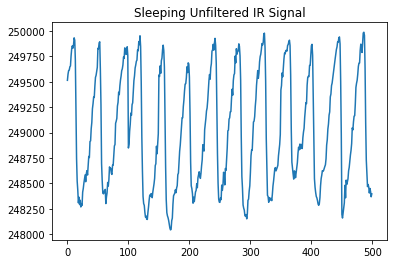

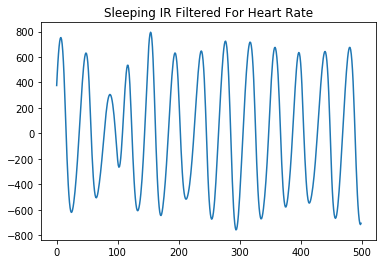

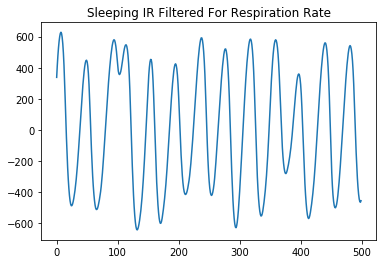

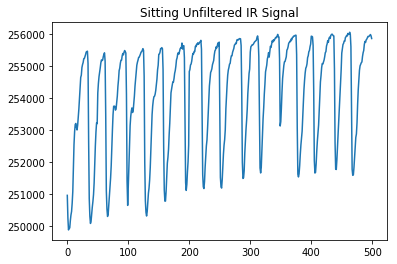

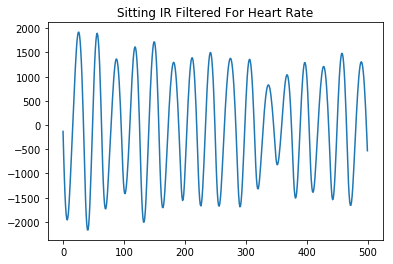

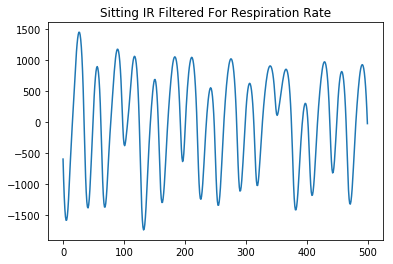

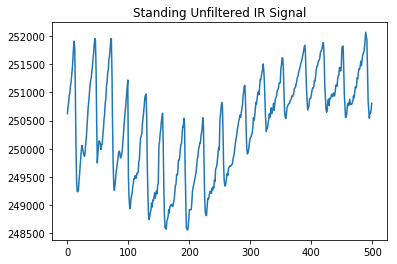

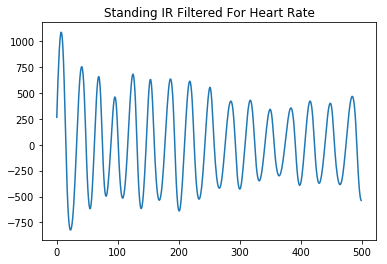

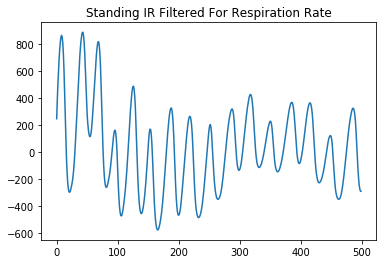

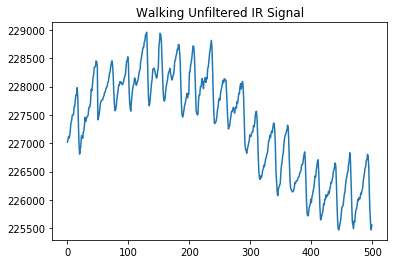

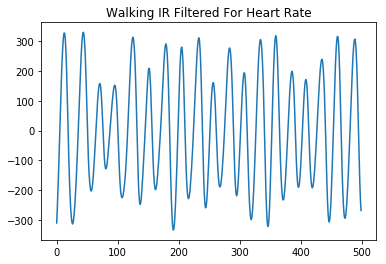

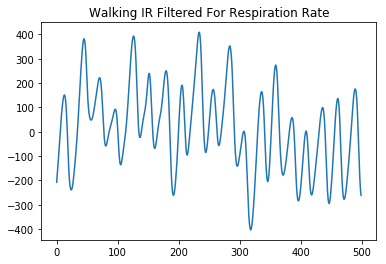

In [37]:
for i in range(0, len(test_sets)):
    
    sensor_data = test_sets[i]
    set_name = test_set_names[i]
    
    time = np.array(sensor_data[:,0]) #use the function we came up with earlier to pull out the columns for time, ir, red
    time = time - time.min()

    ir = sensor_data[:,1]
    red = sensor_data[:,2]

    Fs = len(time)/((time.max() - time.min())/1000) # Sampling Rate in Hz
    Ts = 1.0/Fs # sampling interval

    #Cutoff frequencies in Hz
    heart_rate_lowcut = 0.8
    heart_rate_highcut = 1.8

    respiration_lowcut = 0.2
    respiration_highcut = 1.5

    #filter data
    filtered_heart_rate_ir = butter_bandpass_filter(ir, heart_rate_lowcut, heart_rate_highcut, Fs, order=1)
    filtered_respiration_ir = butter_bandpass_filter(ir, respiration_lowcut, respiration_highcut, Fs, order=1)

    plt.plot(ir[50:550])
    plt.title("{} Unfiltered IR Signal".format(set_name))
    plt.show()

    plt.plot(filtered_heart_rate_ir[50:550])
    plt.title("{} IR Filtered For Heart Rate".format(set_name))
    plt.show()

    plt.plot(filtered_respiration_ir[50:550])
    plt.title("{} IR Filtered For Respiration Rate".format(set_name))
    plt.show()
    


In [38]:
hr_means = [-1] * len(test_sets)
rr_means = [-1] * len(test_sets)
spo2_means = [-1] * len(test_sets)

hr_exports = [None] * len(test_sets)
rr_exports = [None] * len(test_sets)
spo2_exports = [None] * len(test_sets)

hr_times = [None] * len(test_sets)
rr_times = [None] * len(test_sets)
spo2_times = [None] * len(test_sets)

for i in range(0, len(test_sets)):
    
    sensor_data = test_sets[i]
    set_name = test_set_names[i]
    
    time = np.array(sensor_data[:,0]) #use the function we came up with earlier to pull out the columns for time, ir, red
    time = time - time.min()

    ir = sensor_data[:,1]
    red = sensor_data[:,2]

    Fs = len(time)/((time.max() - time.min())/1000) # Sampling Rate in Hz
    Ts = 1.0/Fs # sampling interval

    #Cutoff frequencies in Hz
    heart_rate_lowcut = 0.8
    heart_rate_highcut = 1.8

    respiration_lowcut = 0.2
    respiration_highcut = 1.5

    #filter data
    filtered_heart_rate_ir = butter_bandpass_filter(ir, heart_rate_lowcut, heart_rate_highcut, Fs, order=1)
    filtered_respiration_ir = butter_bandpass_filter(ir, respiration_lowcut, respiration_highcut, Fs, order=1)    

    #--------------------
    #---- HR Calc -----
    #--------------------

    hrPeaks = signal.argrelextrema(filtered_heart_rate_ir, np.greater_equal, order=25)[0] 

    hr_window_size = 10
    heartRates = np.zeros(len(hrPeaks))
    heartRateTimeStampes = np.zeros(len(hrPeaks)//hr_window_size)
    print('---------- {} HR VALUES -----------'.format(set_name))
    heartRates = np.zeros(len(hrPeaks))
    for peakIndex in range(len(hrPeaks) - 1):
        if (peakIndex % hr_window_size) == 0 and peakIndex + hr_window_size < len(hrPeaks):
            heartRateTimeStampes[peakIndex//hr_window_size] = time[hrPeaks[peakIndex]]

        distance = time[hrPeaks[peakIndex + 1]] - time[hrPeaks[peakIndex]]
        heartRates[peakIndex] = (60000 / distance)
    if not len(heartRates) % hr_window_size == 0:
        heartRates = heartRates[:-(len(heartRates) % hr_window_size)]
    heartRates = np.mean(heartRates.reshape(-1, hr_window_size),axis=1)
    for r in heartRates:
        print(r)
    print('Mean: {}'.format(np.array(heartRates).mean()))
    hr_means[i] = np.array(heartRates).mean()
    hr_exports[i] = heartRates
    hr_times[i] = heartRateTimeStampes
    print('---------- END {} HR VALUES ---------------'.format(set_name))

    #--------------------
    #---- RR Calc -----
    #--------------------

    rrPeaks = signal.argrelextrema(filtered_respiration_ir, np.greater_equal, order=100)[0]

    rr_window_size = 10
    rRates = np.zeros(len(rrPeaks))
    rRateTimeStampes = np.zeros(len(rrPeaks)//rr_window_size)
    print('---------- {} RR VALUES -----------'.format(set_name))
    for peakIndex in range(len(rrPeaks) - 1):
        if (peakIndex % rr_window_size) == 0 and peakIndex + rr_window_size <= len(rrPeaks):
            rRateTimeStampes[peakIndex//rr_window_size] = time[rrPeaks[peakIndex]]

        distance = time[rrPeaks[peakIndex + 1]] - time[rrPeaks[peakIndex]]
        rRates[peakIndex] = (60000 / distance)
    if not len(rRates) % rr_window_size == 0:
        rRates = rRates[:-(len(rRates) % rr_window_size)]
    rRates = np.mean(rRates.reshape(-1, rr_window_size),axis=1)
    for r in rRates:
        print(r)
    print('Mean: {}'.format(np.array(rRates).mean()))
    rr_means[i] = np.array(rRates).mean()
    rr_exports[i] = rRates
    rr_times[i] = rRateTimeStampes
    print('---------- END {} RR VALUES ---------------'.format(set_name))

    #--------------------
    #---- SPO2 Calc -----
    #--------------------

    spo2_window_size_seconds = 3

    ir_spo2 = np.reshape(ir, len(ir))
    red_spo2 = np.reshape(red, len(red))  # shape them

    b, a = signal.butter(4, 0.8, btype='lowpass') #filter for SPO2, just removing hf noise
    filtIR = signal.filtfilt(b, a, ir_spo2, method='gust') #using filtfilt to avoid phase shift
    filtRed = signal.filtfilt(b, a, red_spo2, method='gust') 

    redDC = [] # need relevant arrays
    redAC = []
    irDC = []
    irAC = []
    spo2_timestamps = []

    index = 0
    while True:
        lb, ub = generateWindow(index, spo2_window_size_seconds, Fs) #isolate the chunk we're analyzing now, making sure chunk is big enough to get 2 valleys
        if (ub > len(ir)):
            break
        redSlice = filtRed[lb:ub]
        irSlice = filtIR[lb:ub] #filtered data
        valleys = signal.argrelmin(redSlice, order=10)[0] #find peaks and valleys
        peaks = signal.argrelmax(redSlice, order=10)[0]
        valley1 = valleys[0] + lb
        valley2 = valleys[1] + lb
        peak = peaks[0] + lb
        if (peak < valley1): #to make sure the peak is between the valleys
            peak = peaks[1] + lb
        dcir = np.interp(peak, [valley1, valley2], [filtIR[valley1], filtIR[valley2]])
        dcred = np.interp(peak, [valley1, valley2], [filtRed[valley1], filtRed[valley2]])
        testSPO2 = calculateSPO2(getRatio(filtRed[peak] - dcred, dcir, filtIR[peak] - dcir, dcred))
        if testSPO2 < 96.0 or testSPO2 > 99.9: # garbage value? let's try searching for peaks dynamically
            attempts = 0
            while (testSPO2 < 96.0 or testSPO2 > 99.9) and attempts < 14 : # try orders from 6 - 19
                valleys = signal.argrelmin(redSlice, order=6 + attempts)[0] #find peaks and valleys
                peaks = signal.argrelmax(redSlice, order=6 + attempts)[0]
                if (len(valleys) < 2 or len(peaks) < 2):
                    break; # no peaks or valleys?
                valley1 = valleys[0] + lb
                valley2 = valleys[1] + lb
                peak = peaks[0] + lb
                if (peak < valley1): #to make sure the peak is between the valleys
                    peak = peaks[1] + lb
                dcir = np.interp(peak, [valley1, valley2], [filtIR[valley1], filtIR[valley2]])
                dcred = np.interp(peak, [valley1, valley2], [filtRed[valley1], filtRed[valley2]])
                attempts = attempts + 1
        irDC += [dcir]
        irAC += [filtIR[peak] - dcir]
        redDC += [dcred]
        redAC += [filtRed[peak] - dcred]
        spo2_timestamps.append(time[index])

        index = ub

    print('---------- {} SPO2 VALUES -----------'.format(set_name))
    spo2s = []
    for iteration in range(len(redDC)):
        spo2_val = calculateSPO2(getRatio(redAC[iteration], irDC[iteration], irAC[iteration], redDC[iteration]))
        
        # If spo2 value is nonsese, change it to 100 to not have a signficant effect on calculating the mean. 
        # 100 means spo2 calculation failed
        if spo2_val < 70 or spo2_val > 100:
            spo2_val = 100
            
        spo2s.append(spo2_val)
        print(spo2_val)
    print('Mean: {}'.format(np.array(spo2s).mean()))
    spo2_means[i] = np.array(spo2s).mean()
    spo2_exports[i] = spo2s
    spo2_times[i] = spo2_timestamps
    print('---------- END {} SPO2 VALUES -----------'.format(set_name))

---------- Sleeping HR VALUES -----------
63.8776946786
64.8345056514
65.5590733424
65.5576579903
64.5915843814
65.4894421833
64.741451994
66.5131963602
64.695834354
64.7639134308
64.9526090294
64.1616931062
64.4784555528
62.2241038122
60.9222847203
60.1199598767
63.3027556178
62.9182708448
61.7160192481
63.4897886852
63.1075083622
59.5419269385
64.0117869577
62.10476197
64.3061108218
66.7305898079
68.5385272154
65.0695732076
62.5570231722
61.9597461845
64.7753862444
65.9613338922
62.6525809539
65.1563781659
64.50994742
64.6899025965
64.106538409
63.8431653773
62.2196646893
63.6991818194
61.4758800621
61.5020097948
63.8415941095
68.1083372715
75.9096171142
71.5298871303
67.1983297781
66.9852789495
65.0379987335
65.5755608675
67.735011716
69.4559849632
66.9243497866
64.0064056964
67.5056935605
69.2150840345
68.9284485341
73.6285584917
73.2108653628
76.3747453324
76.5519715269
73.834650683
70.0075771366
70.3324309115
71.6896726613
67.8576661759
70.2382259223
76.5513603235
68.6697919647
6

---------- Standing SPO2 VALUES -----------
99.5699419518
99.2731254707
99.5517713039
98.8211725309
99.4297111333
99.5749711734
99.6959819089
99.8520341204
99.2805289922
99.241832212
99.187732483
99.0030669628
99.4451880701
99.2596220359
99.3426826777
99.0483615802
99.2759093864
98.868583466
99.3311853145
99.0638665979
99.574767032
99.2048620556
99.3170662092
99.4646565298
99.4361001438
99.1915102929
99.7663015612
99.449855541
99.591931073
99.7333760468
99.9560338328
99.6925546026
98.7150298582
99.5202630896
99.8138131346
99.5419265844
98.4268225124
99.5648668055
99.8155711765
99.1377624128
99.2504960216
99.7600747758
99.2790944235
97.6753110127
99.1627826707
99.4863650849
99.4394930313
99.6154891676
99.1645585855
98.9572959632
99.8474156009
99.1112877014
99.78268907
99.5975690603
99.8136023211
99.7320289214
99.4288755462
99.6447530411
99.5004314261
98.9186432519
98.626766747
99.5566742652
97.386005549
99.6033078888
99.741083648
99.7279730462
99.8712385493
99.3460272498
99.2893933422
9

In [39]:
for i in range(0,len(test_sets)):
    print("{} HR Mean: {}".format(test_set_names[i],hr_means[i]))
    print("{} RR Mean: {}".format(test_set_names[i],rr_means[i]))
    print("{} SPO2 Mean: {}\n".format(test_set_names[i],spo2_means[i]))

Sleeping HR Mean: 66.37468241702226
Sleeping RR Mean: 14.670739312120674
Sleeping SPO2 Mean: 99.84137137752131

Sitting HR Mean: 81.32085938612151
Sitting RR Mean: 12.331209762477295
Sitting SPO2 Mean: 99.6800625924227

Standing HR Mean: 77.5396463991716
Standing RR Mean: 13.041656969786219
Standing SPO2 Mean: 99.35413408247318

Walking HR Mean: 63.244851663549156
Walking RR Mean: 13.446284194788802
Walking SPO2 Mean: 97.66630713644196



Below are the required plots:

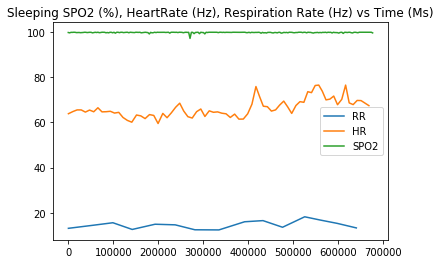

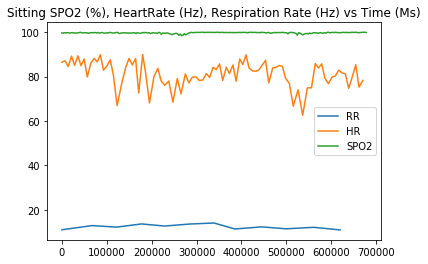

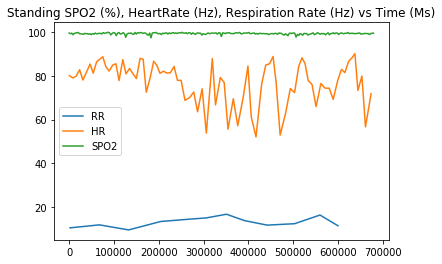

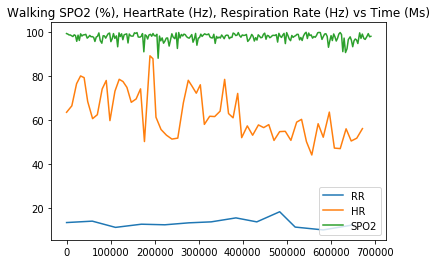

In [40]:
for i in range(0,len(test_sets)):
    plt.plot(rr_times[i],rr_exports[i],label="RR")
    plt.plot(hr_times[i],hr_exports[i],label="HR")
    plt.plot(spo2_times[i], spo2_exports[i],label="SPO2")
    plt.legend()
    plt.title("{} SPO2 (%), HeartRate (Hz), Respiration Rate (Hz) vs Time (Ms)".format(test_set_names[i]))
    plt.show()

Here we export requested values to a csv:

In [41]:
for i in range(0,len(test_sets)):
    test_data = test_sets[i]
    
    d = {'IR': pd.Series(test_data[:,1]),
         'RED': pd.Series(test_data[:,2]),
         'X': pd.Series(test_data[:,3]),
         'Y': pd.Series(test_data[:,4]),
         'Z': pd.Series(test_data[:,5]),
         'Heart Rate': pd.Series(hr_exports[i]),
         'Respiration Rate': pd.Series(rr_exports[i]),
         'SPO2': pd.Series(spo2_exports[i]),
         'Classifier Error Rate': pd.Series(error_rates[i])
        }
    
    export_df = pd.DataFrame(d)
    export_df = export_df[['IR','RED','X','Y','Z','Heart Rate','Respiration Rate','SPO2','Classifier Error Rate']]
    export_df.to_csv("team8_assignment7_{}.csv".format(test_set_names[i]), index=False)